In [1]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

### Setup
First run the queries:
```
mimic-code/etc/ventilation-durations.sql
mimic-code/etc/echo-data.sql
src/echo_icustay.sql
```
to generate the prerequisite tables

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = \
"""
SELECT icustay_id, charttime, itemid, value FROM chartevents
where value is not null
and itemid in
(
     640 -- extubated
     , 648 -- speech
     , 720 -- vent type
     , 467 -- O2 delivery device
     , 445, 448, 449, 450, 1340, 1486, 1600, 224687 -- minute volume
     , 639, 654, 681, 682, 683, 684,224685,224684,224686 -- tidal volume
     , 218,436,535,444,459,224697,224695,224696,224746,224747 -- High/Low/Peak/Mean/Neg insp force ("RespPressure")
     , 221,1,1211,1655,2000,226873,224738,224419,224750,227187 -- Insp pressure
     , 543 -- PlateauPressure
     , 5865,5866,224707,224709,224705,224706 -- APRV pressure
     , 60,437,505,506,686,220339,224700 -- PEEP
     , 3459 -- high pressure relief
     , 501,502,503,224702 -- PCV
     , 223,667,668,669,670,671,672 -- TCPCV
     , 157,158,1852,3398,3399,3400,3401,3402,3403,3404,8382,227809,227810 -- ETT
     , 224701 -- PSVlevel
)

"""
ce = pd.read_sql_query(query, con)
#ventilation.icustay_id = ventilation.icustay_id.astype(int)
ce.head()

,icustay_id,charttime,itemid,value
0,254478.0,2108-08-26 07:00:00,158,Done
1,232669.0,2104-08-08 11:00:00,158,Done
2,254478.0,2108-08-27 11:00:00,158,Done
3,220597.0,2149-11-10 17:00:00,158,Done
4,254478.0,2108-08-23 11:00:00,158,Done


In [5]:
ce.loc[ce.itemid == 640].value.unique()

array(['Fluid Bolus', 'Other/Remarks', 'Chest Pain', 'Extubated',
       'Cardioversion', 'OR Sent', 'OR Received', 'Dysrhythmia',
       'Defibrillation', 'Cardiac Arrest', 'Chest Opened', 'Resp Distress',
       'Intubated', 'NeuroAcuteChange', 'Self Extubation', 'Resp Arrest',
       'Retroper Bleed', 'Pneumothorax', 'Trach Changed', 'Tamponade',
       'Pacer External'], dtype=object)

In [6]:
## CPAP mask and bipap mask are non-invasive breathing devices, but count as ventillation
ce.loc[ce.itemid == 467].value.unique()

array(['Hi Flow Neb', 'Nasal Cannula', 'Face Tent', 'Non-Rebreather',
       'None', 'Ventilator', 'Cannula', 'Aerosol-Cool', 'Trach Mask',
       'Venti Mask', 'Medium Conc Mask', 'Bipap Mask', 'Other/Remarks',
       'T-Piece', 'CPAP Mask', 'TranstrachealCat', 'Heated Neb', 'Hood',
       'Vapotherm', 'Hut', 'Ultrasonic Neb'], dtype=object)

In [9]:
ce.loc[ce.itemid == 720].value.unique()

array(['SIMV+PS', 'Assist Control', 'SIMV', 'CPAP+PS', 'Pressure Support',
       'Other/Remarks', 'Pressure Control', 'CMV', 'TCPCV', 'CPAP'], dtype=object)

In [7]:
ce.loc[ce.itemid == 648].value.unique()

array(['Garbled', 'Normal', 'Slurred', 'Intubated/trach', 'Aphasic',
       'Other/Remarks', 'None', 'Mute'], dtype=object)

In [8]:
ce.value.unique()

array(['Done', '33%', '0', ..., '2132', '1419', '-39'], dtype=object)

### Load the ventilation durations

In [4]:
query = \
"""
SELECT * FROM ventdurations;
"""
ventilation = pd.read_sql_query(query, con)
#ventilation.icustay_id = ventilation.icustay_id.astype(int)
ventilation.head()

,icustay_id,ventnum,starttime,endtime,duration_hours
0,200003.0,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000
1,200006.0,1,2159-09-03 13:00:00,2159-09-04 03:50:00,14.833333
2,200009.0,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
3,200011.0,1,2188-08-06 01:00:00,2188-08-06 04:00:00,3.000000
4,200014.0,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000


In [5]:
np.isnan(ventilation.icustay_id).sum()

56

In [6]:
## filter out ventilation events without an icustay id
ventilation = ventilation.loc[~np.isnan(ventilation.icustay_id)]
ventilation.icustay_id = ventilation.icustay_id.astype(int)
ventilation.head()

,icustay_id,ventnum,starttime,endtime,duration_hours
0,200003,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000
1,200006,1,2159-09-03 13:00:00,2159-09-04 03:50:00,14.833333
2,200009,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
3,200011,1,2188-08-06 01:00:00,2188-08-06 04:00:00,3.000000
4,200014,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000


How many ventilation events are there?

In [7]:
len(ventilation)

38365

Are there any ICU stays with multiple ventilation events?

In [8]:
print(len(ventilation.icustay_id.unique()))
len(ventilation.icustay_id.unique()) != len(ventilation)

27792


True

Histogram showing the distribution of the number of hours patients were on the ventilator

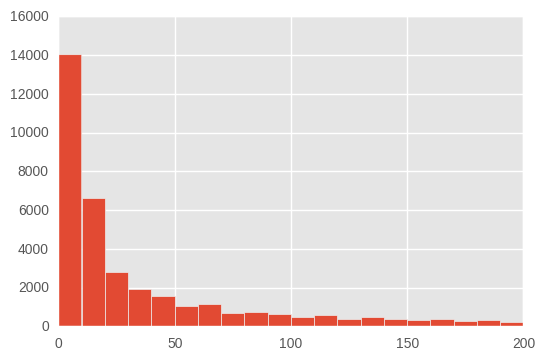

In [9]:
ax = (ventilation.duration_hours).hist(range=(0,200), bins=20)

### Load the ICU echos

In [10]:
query = \
"""
SELECT * FROM echo_icustay;
"""
echo_icustay = pd.read_sql_query(query, con).sort_values(by='icustay_id')
echo_icustay.head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,outtime,gender,subject_id,...,admittime,dischtime,ethnicity,age,diagnosis,time_to_echo,max_icustay_seq,time_filter,single_stay_filter,age_filter
24814,83481,163557,2199-08-03 12:40:00,200003,6.0,1,Y,2199-08-08 17:09:18,M,27513,...,2199-08-02 17:02:00,2199-08-22 19:00:00,WHITE,17625 days 17:02:00,S/P RESECTION,0 days 19:38:00,1,True,True,True
11629,73364,129310,2109-02-19 13:40:00,200007,1.0,1,Y,2109-02-18 17:03:12,M,20707,...,2109-02-17 10:02:00,2109-02-20 15:47:00,WHITE,15818 days 10:02:00,RULE-OUT MYOCARDIAL INFARCTION,2 days 03:38:00,1,False,True,True
11731,99984,129607,2189-12-01 08:34:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,2189-11-30 10:45:00,2189-12-06 15:00:00,WHITE,17353 days 10:45:00,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0 days 21:49:00,1,True,True,True
11730,99985,129607,2189-12-01 08:46:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,2189-11-30 10:45:00,2189-12-06 15:00:00,WHITE,17353 days 10:45:00,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0 days 22:01:00,1,True,True,True
10799,71333,127229,2105-02-18 16:51:00,200014,2.0,1,Y,2105-02-18 16:53:29,M,9514,...,2105-02-16 23:15:00,2105-02-21 13:46:00,UNKNOWN/NOT SPECIFIED,30921 days 23:15:00,ABDOMINAL AORTIC ANEURYSM,1 days 17:36:00,1,True,True,True


In [11]:
len(echo_icustay)

39051

In [12]:
len(echo_icustay.row_id.unique())

33904

### Intersect the ventilation events with the ICU echos

In [13]:
vent_echos = echo_icustay.merge(ventilation, how='inner', on='icustay_id')
vent_echos.head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,outtime,gender,subject_id,...,diagnosis,time_to_echo,max_icustay_seq,time_filter,single_stay_filter,age_filter,ventnum,starttime,endtime,duration_hours
0,83481,163557,2199-08-03 12:40:00,200003,6.0,1,Y,2199-08-08 17:09:18,M,27513,...,S/P RESECTION,0 days 19:38:00,1,True,True,True,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000
1,99984,129607,2189-12-01 08:34:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0 days 21:49:00,1,True,True,True,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
2,99985,129607,2189-12-01 08:46:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0 days 22:01:00,1,True,True,True,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
3,71333,127229,2105-02-18 16:51:00,200014,2.0,1,Y,2105-02-18 16:53:29,M,9514,...,ABDOMINAL AORTIC ANEURYSM,1 days 17:36:00,1,True,True,True,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000
4,77556,112486,2178-07-08 12:15:00,200019,3.0,1,Y,2178-07-11 10:28:40,F,21789,...,CEREBROVASCULAR ACCIDENT,0 days 03:13:00,1,True,True,True,1,2178-07-08 09:00:00,2178-07-09 14:00:00,29.000000


In [14]:
vent_echos['on_ventilator_during_echo'] = (vent_echos.starttime <= vent_echos.charttime) & (vent_echos.endtime >= vent_echos.charttime)
vent_echos['on_ventilator_anytime'] = True
vent_echos.head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,outtime,gender,subject_id,...,max_icustay_seq,time_filter,single_stay_filter,age_filter,ventnum,starttime,endtime,duration_hours,on_ventilator_during_echo,on_ventilator_anytime
0,83481,163557,2199-08-03 12:40:00,200003,6.0,1,Y,2199-08-08 17:09:18,M,27513,...,1,True,True,True,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000,False,True
1,99984,129607,2189-12-01 08:34:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,1,True,True,True,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333,True,True
2,99985,129607,2189-12-01 08:46:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,1,True,True,True,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333,True,True
3,71333,127229,2105-02-18 16:51:00,200014,2.0,1,Y,2105-02-18 16:53:29,M,9514,...,1,True,True,True,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000,False,True
4,77556,112486,2178-07-08 12:15:00,200019,3.0,1,Y,2178-07-11 10:28:40,F,21789,...,1,True,True,True,1,2178-07-08 09:00:00,2178-07-09 14:00:00,29.000000,True,True


In [15]:
## some echos have more than one ventilation event associated with them above
## because there can be multiple ventilation events in one icustay
vent_echos_unique = vent_echos[['row_id', 'on_ventilator_during_echo', 'on_ventilator_anytime']].groupby('row_id').any(axis=0)
vent_echos_unique.reset_index(inplace=True)
vent_echos_unique.head()

,row_id,on_ventilator_anytime,on_ventilator_during_echo
0,59655,True,True
1,59657,True,True
2,59659,True,True
3,59664,True,False
4,59665,True,False


In [16]:
echo_icustay_vent = echo_icustay.merge(vent_echos_unique
                                      , how='left', on='row_id')
echo_icustay_vent['on_ventilator_during_echo'].fillna(False, inplace=True)
echo_icustay_vent['on_ventilator_anytime'].fillna(False, inplace=True)
echo_icustay_vent.head()

,row_id,hadm_id,charttime,icustay_id,los_icu,icustay_seq,first_icu_stay,outtime,gender,subject_id,...,ethnicity,age,diagnosis,time_to_echo,max_icustay_seq,time_filter,single_stay_filter,age_filter,on_ventilator_anytime,on_ventilator_during_echo
0,83481,163557,2199-08-03 12:40:00,200003,6.0,1,Y,2199-08-08 17:09:18,M,27513,...,WHITE,17625 days 17:02:00,S/P RESECTION,0 days 19:38:00,1,True,True,True,True,False
1,73364,129310,2109-02-19 13:40:00,200007,1.0,1,Y,2109-02-18 17:03:12,M,20707,...,WHITE,15818 days 10:02:00,RULE-OUT MYOCARDIAL INFARCTION,2 days 03:38:00,1,False,True,True,False,False
2,99984,129607,2189-12-01 08:34:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,WHITE,17353 days 10:45:00,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0 days 21:49:00,1,True,True,True,True,True
3,99985,129607,2189-12-01 08:46:00,200009,2.0,1,Y,2189-12-02 14:17:37,F,29904,...,WHITE,17353 days 10:45:00,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0 days 22:01:00,1,True,True,True,True,True
4,71333,127229,2105-02-18 16:51:00,200014,2.0,1,Y,2105-02-18 16:53:29,M,9514,...,UNKNOWN/NOT SPECIFIED,30921 days 23:15:00,ABDOMINAL AORTIC ANEURYSM,1 days 17:36:00,1,True,True,True,True,False


In [17]:
len(echo_icustay_vent)

39051

How many ICU echos where the patient was on ventilation during the procedure?

In [18]:
echo_icustay_vent.on_ventilator_during_echo.sum()

9156

How many ICU echos where the patient was on ventilation at anytime during that ICU stay?

In [19]:
echo_icustay_vent.on_ventilator_anytime.sum()

25672

Apply the single stay filter first

In [20]:
echo_icustay_vent_ssfiltered = echo_icustay_vent.loc[echo_icustay_vent.single_stay_filter]
print 'Total single stay echos:', len(echo_icustay_vent_ssfiltered)
print 'Single stay echos on ventilator:', echo_icustay_vent_ssfiltered.on_ventilator_during_echo.sum()
print 'Single stay echos on ventilator anytime during ICU stay:', echo_icustay_vent_ssfiltered.on_ventilator_anytime.sum()

Total single stay echos: 25867
Single stay echos on ventilator: 6076
Single stay echos on ventilator anytime during ICU stay: 16178


Also filtered by time of echo relative to ICU admission first:

In [21]:
echo_icustay_vent_timefiltered = echo_icustay_vent_ssfiltered.loc[echo_icustay_vent_ssfiltered.time_filter]
print 'Total time filtered echos:', len(echo_icustay_vent_timefiltered)
print 'Time filtered echos on ventilator:', echo_icustay_vent_timefiltered.on_ventilator_during_echo.sum()
print 'Time filtered echos on ventilator anytime during ICU stay:', echo_icustay_vent_timefiltered.on_ventilator_anytime.sum()

Total time filtered echos: 14369
Time filtered echos on ventilator: 2885
Time filtered echos on ventilator anytime during ICU stay: 8546


Add in the age filter

In [23]:
echo_icustay_vent_agefiltered = echo_icustay_vent_timefiltered.loc[echo_icustay_vent_timefiltered.age_filter]
print 'Total age filtered echos:', len(echo_icustay_vent_agefiltered)
print 'Age filtered echos on ventilator:', echo_icustay_vent_agefiltered.on_ventilator_during_echo.sum()
print 'Age filtered echos on ventilator anytime during ICU stay:', echo_icustay_vent_agefiltered.on_ventilator_anytime.sum()

Total age filtered echos: 14159
Age filtered echos on ventilator: 2791
Age filtered echos on ventilator anytime during ICU stay: 8437


### Verify that the query produces the same results

In [ ]:
query = \
"""
SELECT * FROM vent_echo;
"""
vent_echo_flags = pd.read_sql_query(query, con)
#ventilation.icustay_id = ventilation.icustay_id.astype(int)
vent_echo_flags.head()

In [ ]:
echo_icustay_vent = echo_icustay.merge(vent_echo_flags
                                      , how='left', on='row_id')

In [ ]:
len(echo_icustay_vent)

How many ICU echos where the patient was on ventilation during the procedure?

In [ ]:
echo_icustay_vent.on_ventilator_during_echo.sum()

How many ICU echos where the patient was on ventilation at anytime during that ICU stay?

In [ ]:
echo_icustay_vent.on_ventilator_anytime.sum()

If filtered by time of echo relative to ICU admission first:

In [ ]:
echo_icustay_vent_timefiltered = echo_icustay_vent.loc[echo_icustay_vent.time_filter]
print 'Total time filtered echos:', len(echo_icustay_vent_timefiltered)
print 'Time filtered echos on ventilator:', echo_icustay_vent_timefiltered.on_ventilator_during_echo.sum()
print 'Time filtered echos on ventilator anytime during ICU stay:', echo_icustay_vent_timefiltered.on_ventilator_anytime.sum()